In [72]:
%matplotlib inline


# Solving Blackjack with Reinforcement Learning


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [1]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import random
import os

import gymnasium as gym

from blackjack import ControlType, BlackJackAgent
import visualize
from visualize import reward_plot, training_plot, create_grids, create_plots, culmulative_return_calculate, reward_count, Reward_compare_plot


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=False, natural=True)

In [16]:
Training_Culmulative_Return_ls = []
Training_reward_moving_average_ls = []
Testing_Culmulative_Return_ls = []
Testing_reward_moving_average_ls = []

.. code:: py

  # Other possible environment configurations are:

  env = gym.make('Blackjack-v1', natural=True, sab=False)
  # Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

  env = gym.make('Blackjack-v1', natural=False, sab=False)
  # Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.




## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [74]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [75]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




# Q-Learning

## Parameters Studies for Q-Learning Algorithm

Discount 

In [ ]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on Q-Learning Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

In [ ]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type == ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on Q-Learning Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

In [ ]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(learning_rate_step,1,discount_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type == ControlType.Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on Q-Learning Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [ ]:
#Training Q-Learning
# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  1%|          | 969/100000 [00:00<00:20, 4831.28it/s]

100%|██████████| 100000/100000 [00:20<00:00, 4805.01it/s]


Save Agent

In [ ]:
#Save Double Q-Learning agent
q_value_file = "q_learning.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with Q-Learning Algorithm

[ 1.00000e+00  0.00000e+00 -1.00000e+00 ... -1.19515e+04 -1.19505e+04
 -1.19515e+04]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.2793 negative:0.6521
Iteration[10000:20000]     positive:0.2985 negative:0.6234
Iteration[20000:30000]     positive:0.3264 negative:0.5744
Iteration[30000:40000]     positive:0.3519 negative:0.541
Iteration[40000:50000]     positive:0.37 negative:0.5108
Iteration[50000:60000]     positive:0.381 negative:0.4886
Iteration[60000:70000]     positive:0.3916 negative:0.4721
Iteration[70000:80000]     positive:0.3917 negative:0.4757
Iteration[80000:90000]     positive:0.3844 negative:0.4878
Iteration[90000:100000]     positive:0.3868 negative:0.4854

====================== Reward Frequency ======================


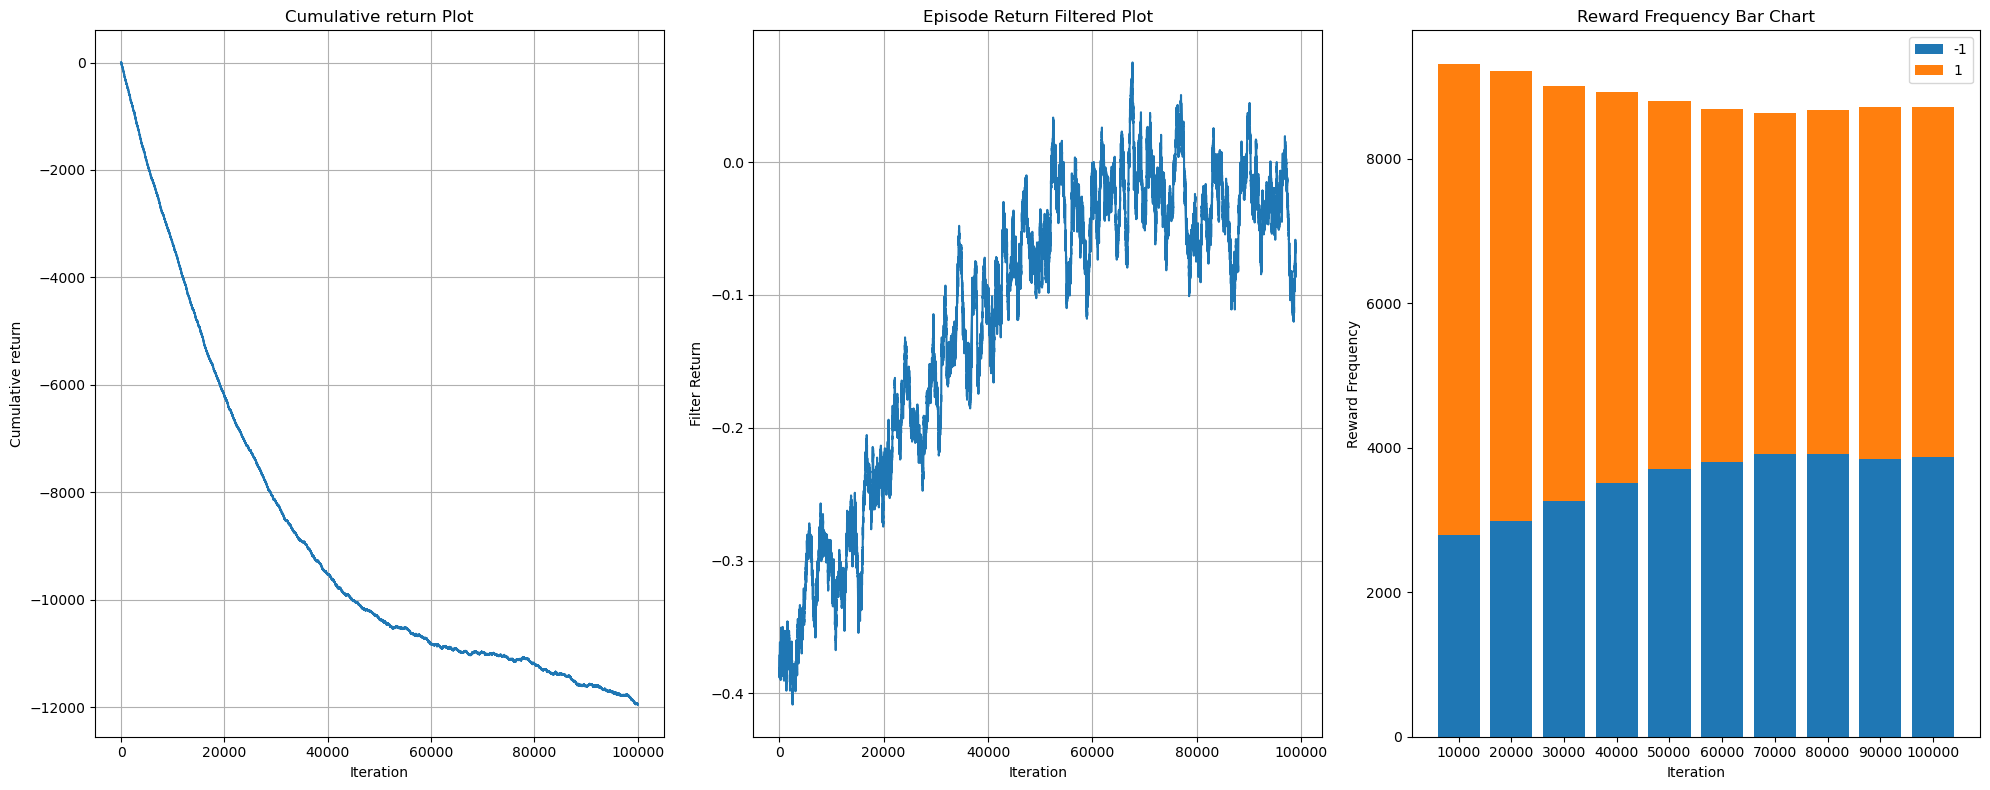

In [ ]:
Training_Q_Learning_Culmulative_Return_np, Training_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_Q_Learning_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_Q_Learning_reward_moving_average)

## Testing Algorithm Performance After Q-Learning iterations training

Load Agent

In [ ]:
#Load Double Q-Learning Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.0
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "q_learning.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(14, 10, 1): [-0.18433351371461296, -0.002355532131535782],
             (21, 10, 1): [2.408436571009574, -0.0001256134460409062],
             (13, 1, 0): [-0.8578865828958018, -0.7858386582644002],
             (9, 3, 0): [-0.18130056171792425, 0.00039083081514029386],
             (21, 6, 1): [2.1474793574871294, -7.3038004196996105e-06],
             (17, 6, 0): [0.08791724282871981, -0.528233862982186],
             (13, 8, 1): [-0.08812477168904989, -0.00019486499931107784],
             (12, 8, 0): [-0.6923137402027155, -0.6296736411324075],
             (13, 8, 0): [-0.7273903130537585, -0.6971393486153781],
             (14, 10, 0): [-1.1085980746863546, -0.9676171040332299],
             (18, 9, 0): [-0.35702596291116506, -0.47405778532610743],
             (12, 1, 0): [-0.6736106214018499, -0.6190188484828645],
             (11, 1, 0): [-0.4078030789081113, -0.0016346417680384467],
   

In [ ]:
#Testing Q-Learning 
env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

100%|██████████| 100000/100000 [00:20<00:00, 4769.14it/s]


## Visualizing the testing with Q-Learning Algorithm




[-1.000e+00 -1.000e+00  0.000e+00 ... -3.561e+03 -3.560e+03 -3.559e+03]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.3862 negative:0.483
Iteration[10000:20000]     positive:0.3914 negative:0.4797
Iteration[20000:30000]     positive:0.39 negative:0.4807
Iteration[30000:40000]     positive:0.3817 negative:0.4881
Iteration[40000:50000]     positive:0.3812 negative:0.4892
Iteration[50000:60000]     positive:0.388 negative:0.4803
Iteration[60000:70000]     positive:0.3805 negative:0.4899
Iteration[70000:80000]     positive:0.3903 negative:0.479
Iteration[80000:90000]     positive:0.3875 negative:0.4892
Iteration[90000:100000]     positive:0.3859 negative:0.4826

====================== Reward Frequency ======================


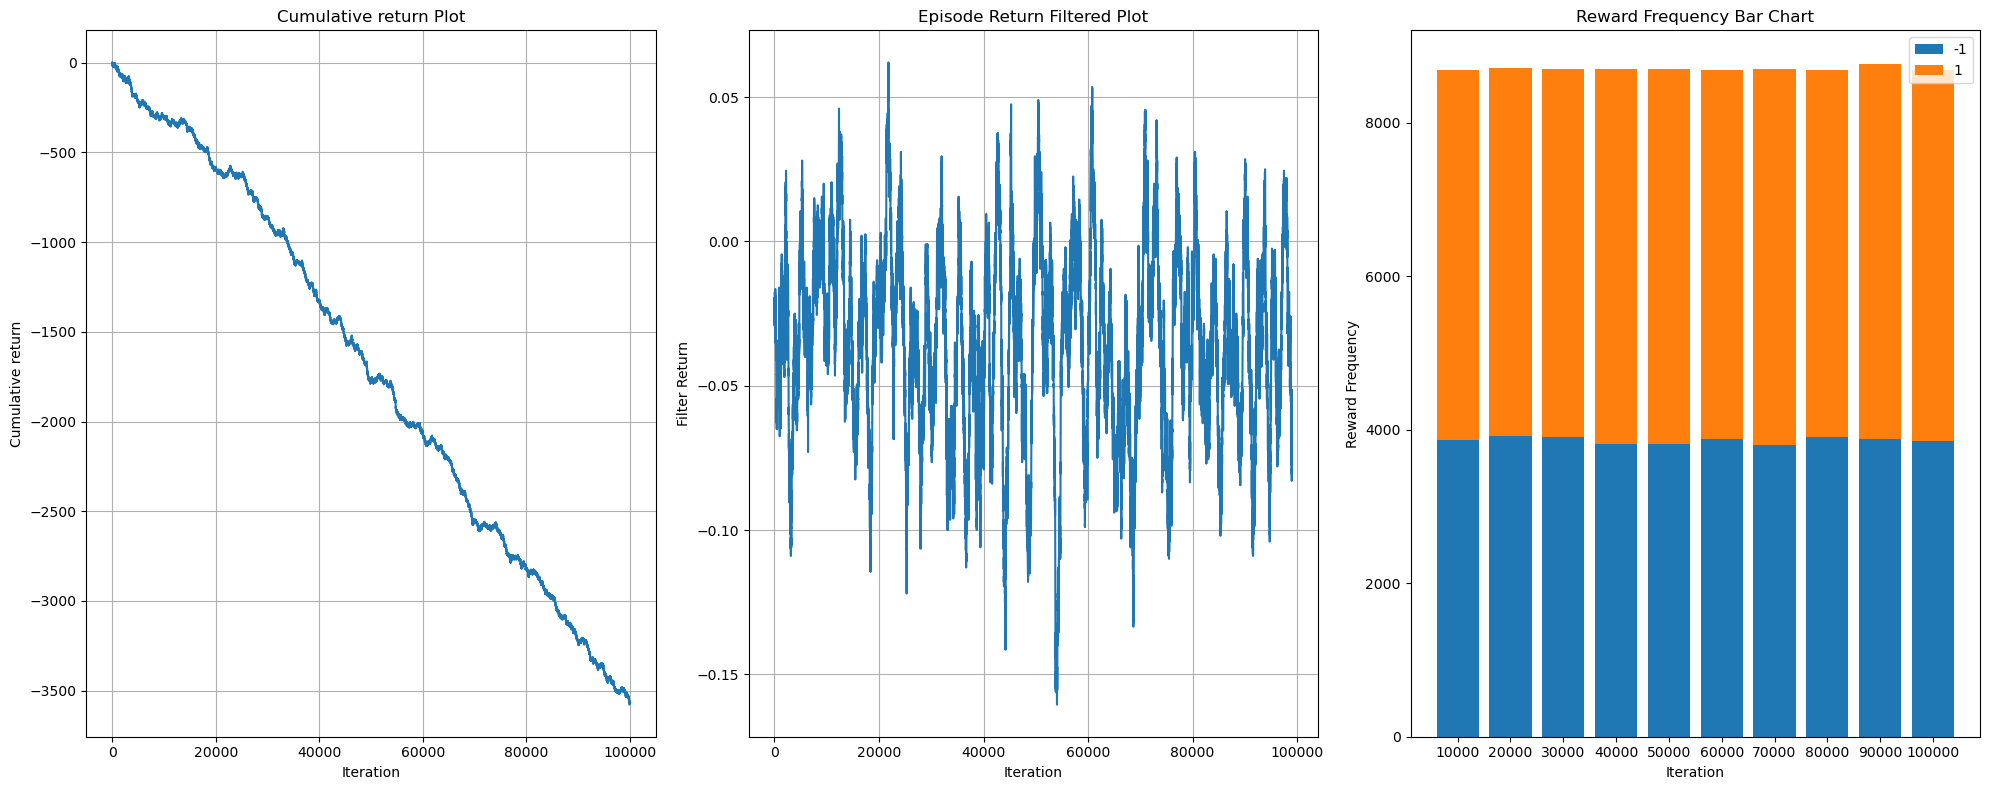

In [ ]:
Testing_Q_Learning_Culmulative_Return_np, Testing_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_Q_Learning_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_Q_Learning_reward_moving_average)

## Visualising the policy



<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




In [ ]:
training_plot(env.return_queue, env.length_queue, agent.training_error, 5000)

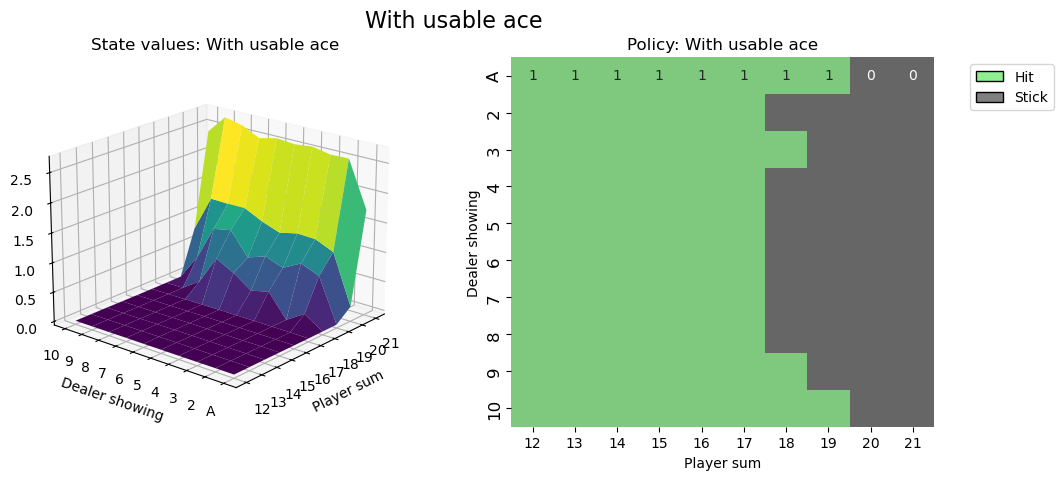

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

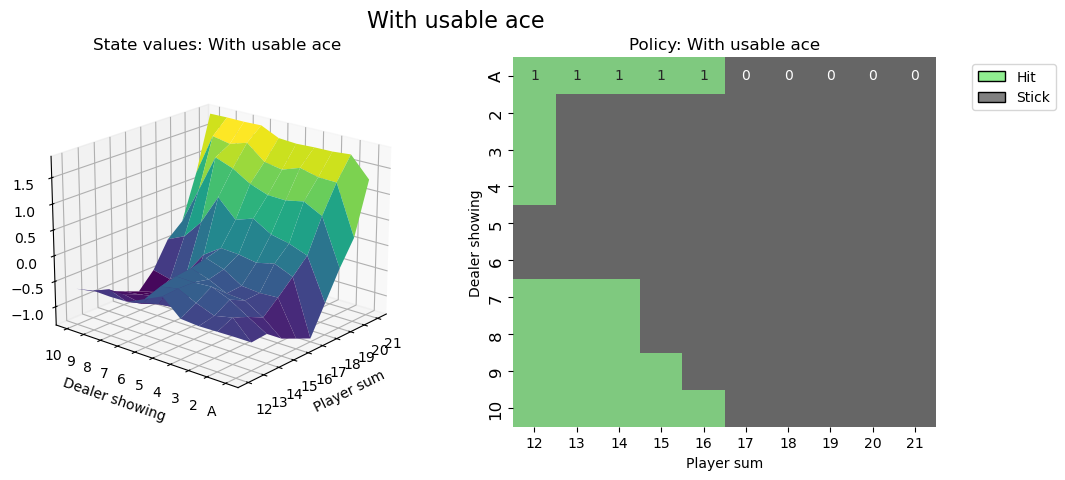

In [ ]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# MC Control

## Parameters Studies for MC Algorithm

Discount 

In [ ]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.MONTE_CARLO

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        history_ls = []

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on MC Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

In [ ]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i

    discount = 0.01

    control_type = ControlType.MONTE_CARLO

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        history_ls = []

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on MC Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [2]:
#Training MC

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=False, natural=True)

Expected_Return = 0
count = 1

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())

  2%|▏         | 1903/100000 [00:00<00:20, 4772.29it/s]

100%|██████████| 100000/100000 [00:22<00:00, 4469.37it/s]


Save Agent

In [4]:
#Save MC agent
q_value_file = "monte_carlo.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with MC Algorithm

[-1.00000e+00 -2.00000e+00 -3.00000e+00 ... -1.19945e+04 -1.19945e+04
 -1.19935e+04]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.2789 negative:0.6532
Iteration[10000:20000]     positive:0.2883 negative:0.628
Iteration[20000:30000]     positive:0.321 negative:0.5807
Iteration[30000:40000]     positive:0.3427 negative:0.5419
Iteration[40000:50000]     positive:0.369 negative:0.5048
Iteration[50000:60000]     positive:0.3893 negative:0.478
Iteration[60000:70000]     positive:0.3891 negative:0.477
Iteration[70000:80000]     positive:0.3873 negative:0.4796
Iteration[80000:90000]     positive:0.3872 negative:0.4828
Iteration[90000:100000]     positive:0.3917 negative:0.4757

====================== Reward Frequency ======================


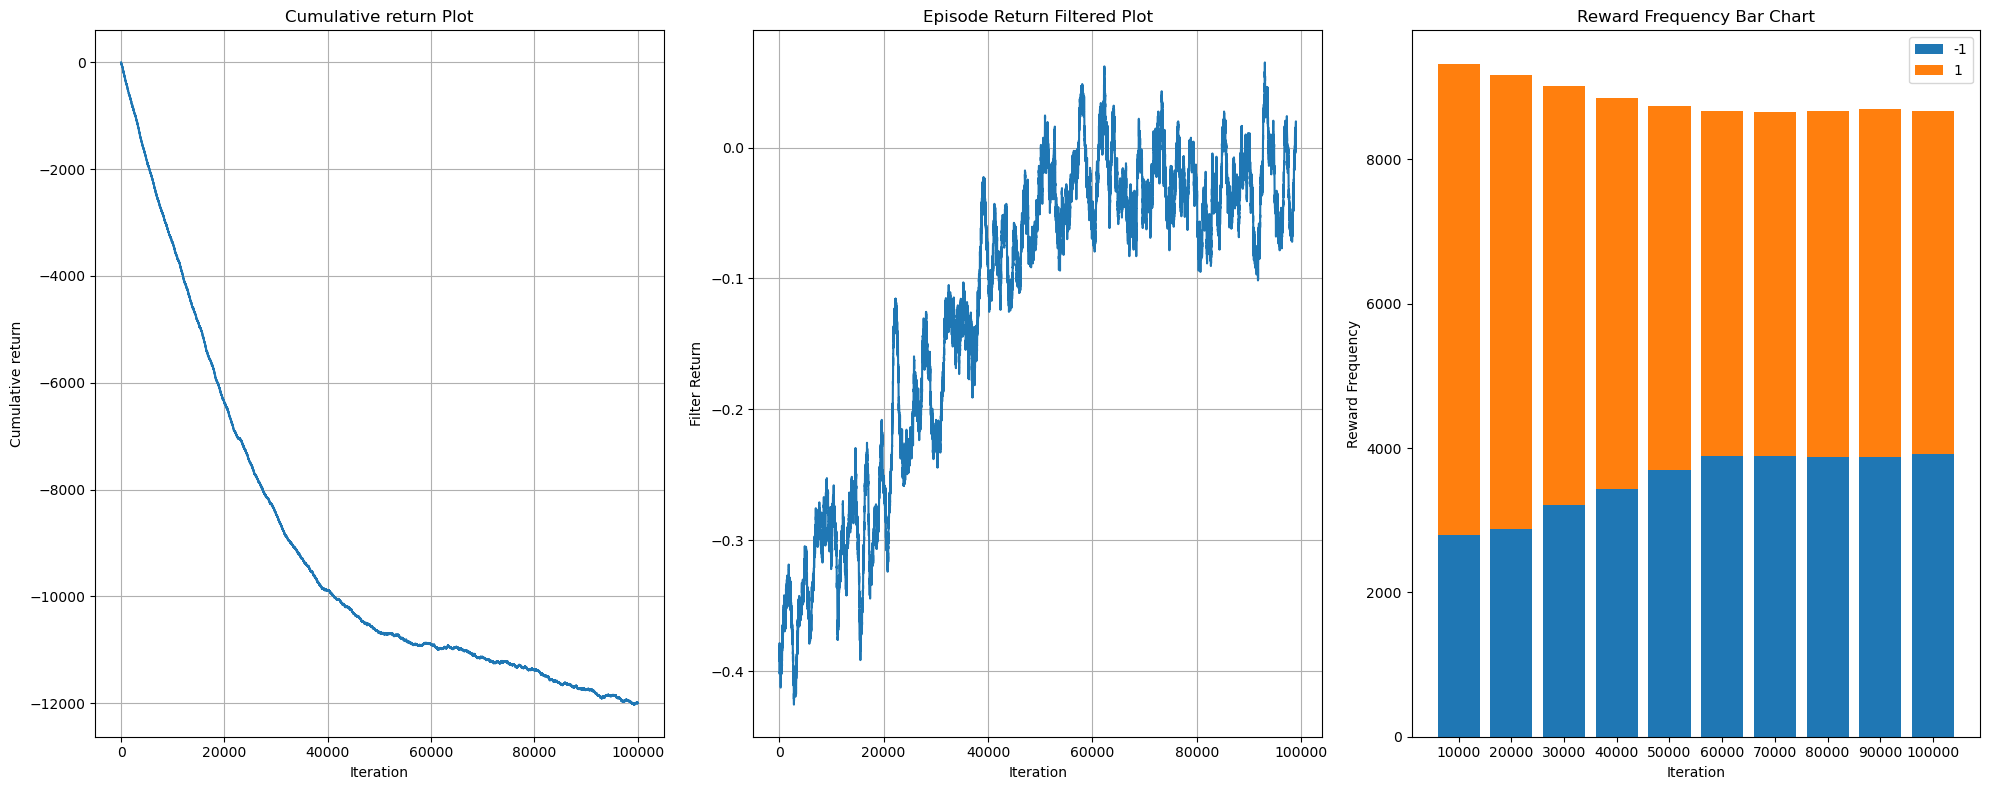

In [3]:
Training_MC_Culmulative_Return_np, Training_MC_reward_moving_average  = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_MC_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_MC_reward_moving_average)

## Testing Algorithm Performance After 100000 iterations training

Load Agent

In [6]:
#Load MC Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.0
discount = 0.01

control_type = ControlType.MONTE_CARLO

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "monte_carlo.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(19, 5, 0): [0.368421052631579, -0.815921052631579],
             (14, 5, 0): [-0.22608695652173905, -0.39627558139534885],
             (17, 10, 0): [-0.4796476306196839, -0.6818758024691354],
             (21, 10, 1): [1.2338760175328756, -0.0028600837438423642],
             (13, 9, 0): [-0.6875, -0.39584717567567573],
             (15, 7, 0): [-0.5449101796407188, -0.5096414600550969],
             (13, 10, 0): [-0.570469798657718, -0.38584177816345927],
             (13, 1, 0): [-0.7606837606837604, -0.36109555408653854],
             (11, 1, 0): [-0.68, -0.0005786562500000007],
             (20, 9, 0): [0.7630799605133276, -0.9303846153846157],
             (16, 2, 0): [-0.3304597701149425, -0.5805357142857144],
             (15, 6, 0): [-0.15337423312883436, -0.49550786516853945],
             (6, 2, 0): [-0.23076923076923075, -0.0024111388888888906],
             (18, 10, 0): [-0.26189683

In [4]:
# Testing MC

env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()

    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

100%|██████████| 100000/100000 [00:28<00:00, 3504.68it/s]


## Visualizing the testing with MC Algorithm




[ 1.000e+00  2.000e+00  1.000e+00 ... -3.308e+03 -3.307e+03 -3.308e+03]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.392 negative:0.4752
Iteration[10000:20000]     positive:0.3817 negative:0.489
Iteration[20000:30000]     positive:0.3815 negative:0.4882
Iteration[30000:40000]     positive:0.3783 negative:0.4847
Iteration[40000:50000]     positive:0.3842 negative:0.4854
Iteration[50000:60000]     positive:0.3993 negative:0.4727
Iteration[60000:70000]     positive:0.3845 negative:0.485
Iteration[70000:80000]     positive:0.393 negative:0.4785
Iteration[80000:90000]     positive:0.385 negative:0.4787
Iteration[90000:100000]     positive:0.3873 negative:0.4791

====================== Reward Frequency ======================


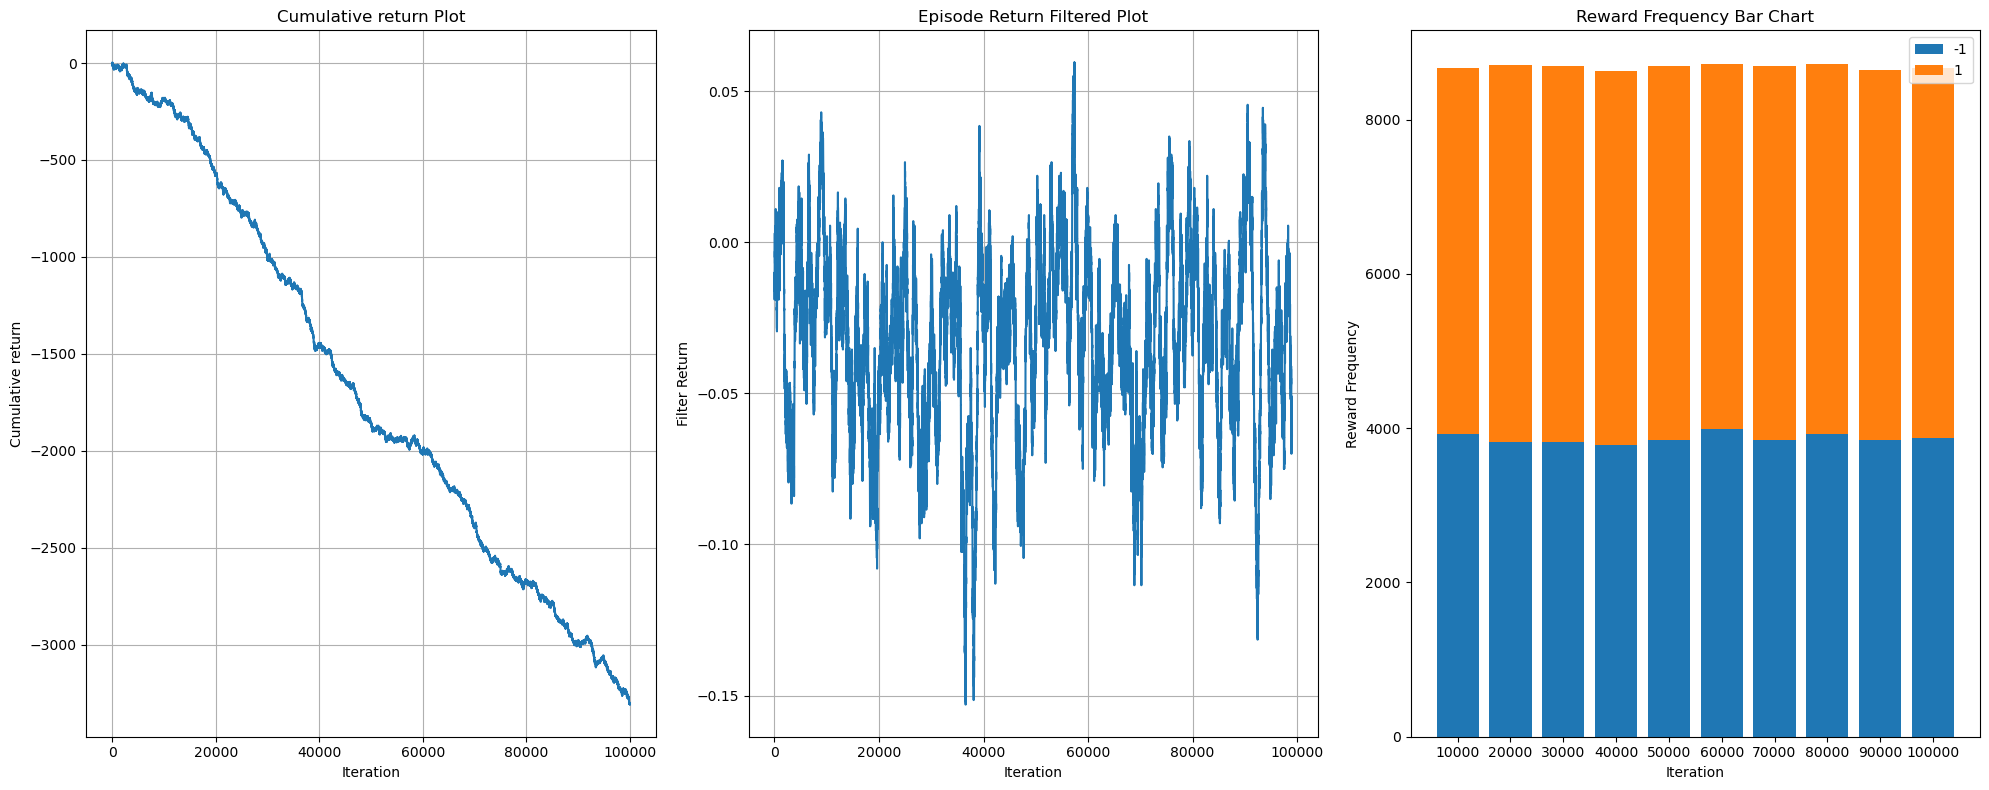

In [5]:
Testing_MC_Culmulative_Return_np, Testing_MC_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_MC_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_MC_reward_moving_average)

## TD Control

## Parameters Studies for SARSA Algorithm

Discount 

In [ ]:
#Discount Hyper Paramter Studied

Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            new_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = new_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on SARSA Algorithm'.format(discount_step))
plt.grid(True)
plt.show()

Epsilon

 29%|██▊       | 2873/10000 [00:00<00:01, 4818.07it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4683.32it/s]


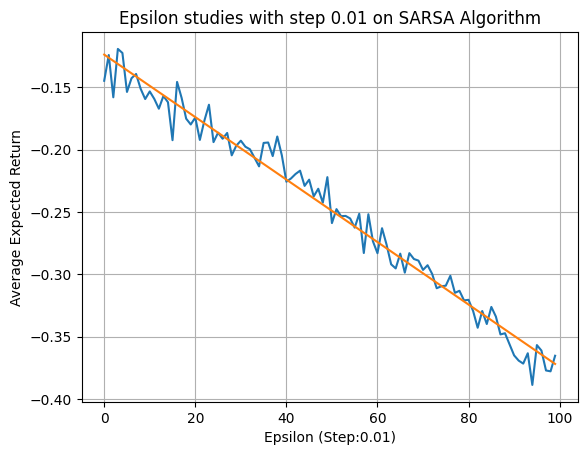

In [ ]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            new_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = new_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on SARSA Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

100%|██████████| 10000/10000 [00:02<00:00, 4938.83it/s]


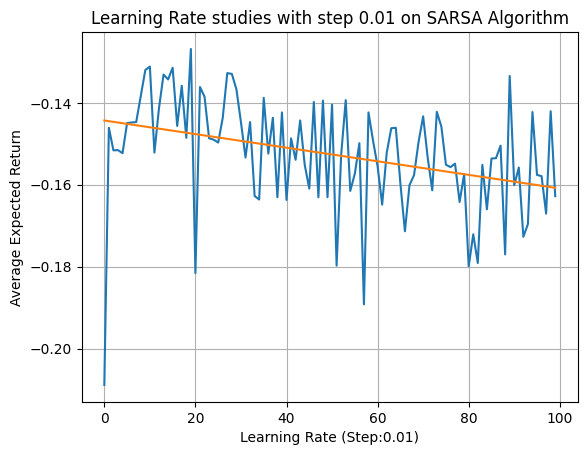

In [ ]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(0,1,discount_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type = ControlType.TEMPORAL_DIFFERENCE

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # Choose a from s using policy derived from Q
        action = agent.get_action(obs)

        # play one episode
        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)
            new_action = agent.get_action(next_obs)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            action = new_action

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on SARSA Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [6]:
#Training SARSA
# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.TEMPORAL_DIFFERENCE

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Choose a from s using policy derived from Q
    action = agent.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        new_action = agent.get_action(next_obs)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = new_action

    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:19<00:00, 5099.34it/s]


Save Agent

In [88]:
#Save SARSA agent
q_value_file = "temporal_difference.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with SARSA Algorithm

[-1.0000e+00  0.0000e+00  1.0000e+00 ... -1.1852e+04 -1.1851e+04
 -1.1852e+04]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.28 negative:0.6554
Iteration[10000:20000]     positive:0.2982 negative:0.622
Iteration[20000:30000]     positive:0.3261 negative:0.576
Iteration[30000:40000]     positive:0.3459 negative:0.5369
Iteration[40000:50000]     positive:0.3728 negative:0.5058
Iteration[50000:60000]     positive:0.3839 negative:0.4768
Iteration[60000:70000]     positive:0.3883 negative:0.4764
Iteration[70000:80000]     positive:0.3844 negative:0.4806
Iteration[80000:90000]     positive:0.3919 negative:0.4782
Iteration[90000:100000]     positive:0.3815 negative:0.4845

====================== Reward Frequency ======================


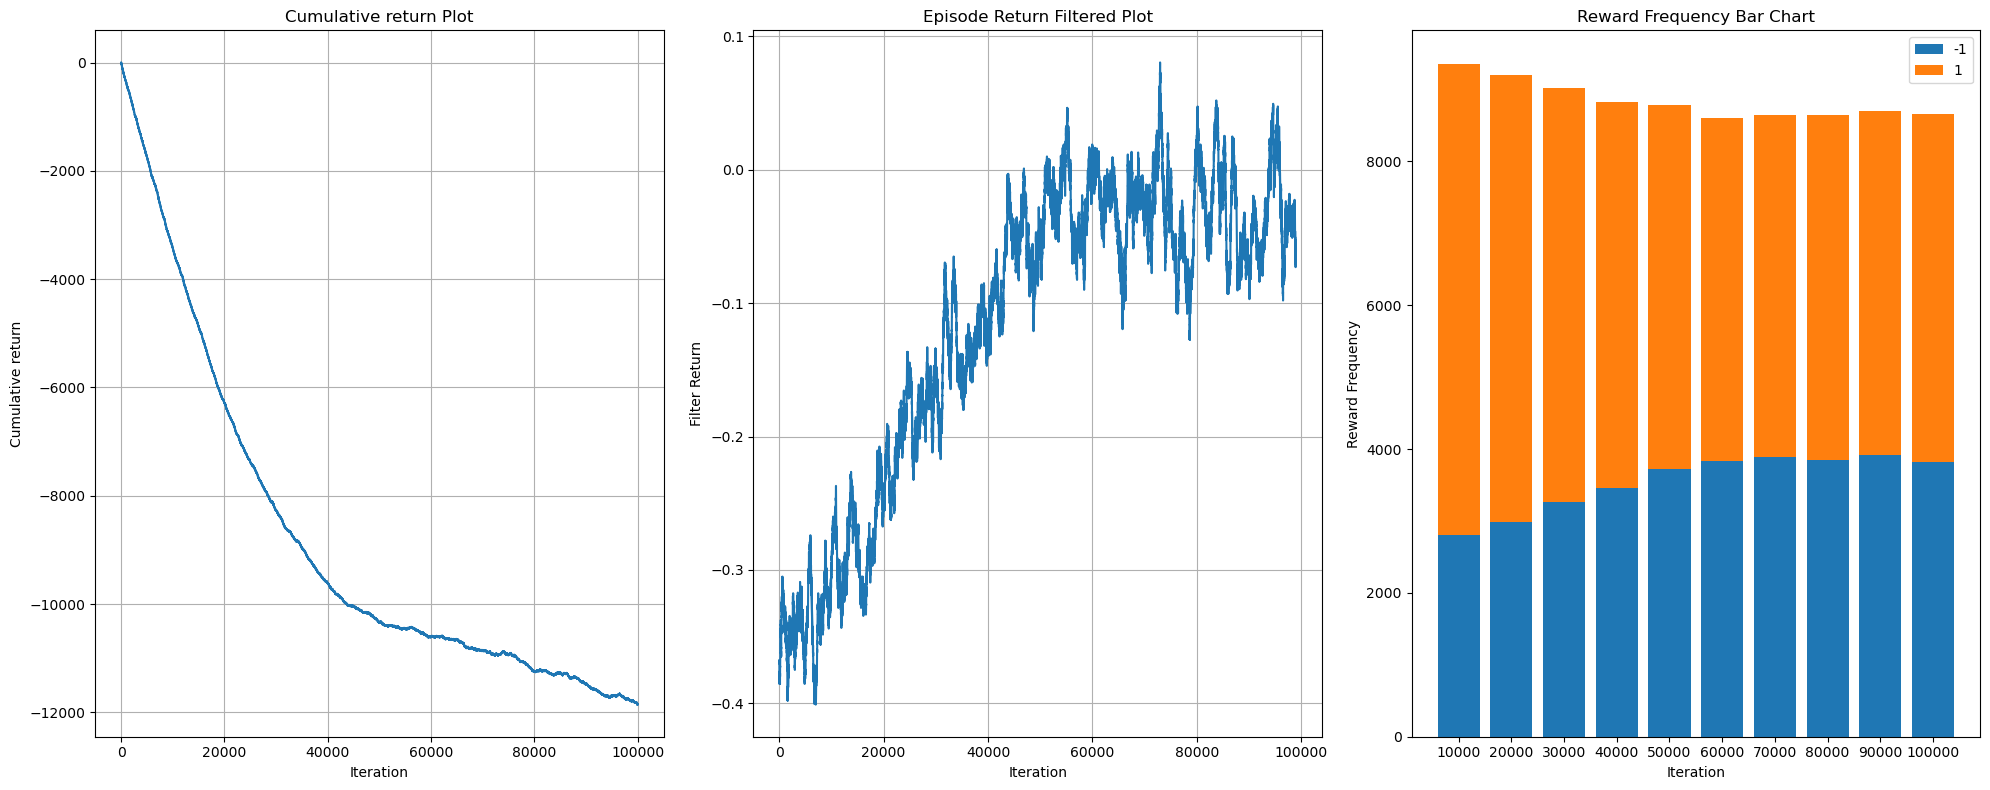

In [7]:
Training_SARSA_Culmulative_Return_np, Training_SARSA_reward_moving_average  = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_SARSA_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_SARSA_reward_moving_average)

Load Agent

In [90]:
#Load SARSA Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.0
discount = 0.01

control_type = ControlType.TEMPORAL_DIFFERENCE

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "temporal_difference.json"
agent.load_model(full_path, q_value_file)

## Testing Algorithm Performance After 100000 iterations training

In [8]:
# Testing SARSA

env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Choose a from s using policy derived from Q
    action = agent.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action = agent.get_action(next_obs)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            next_action=next_action,
            terminated=terminated
        )
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        action = new_action


100%|██████████| 100000/100000 [00:18<00:00, 5361.02it/s]


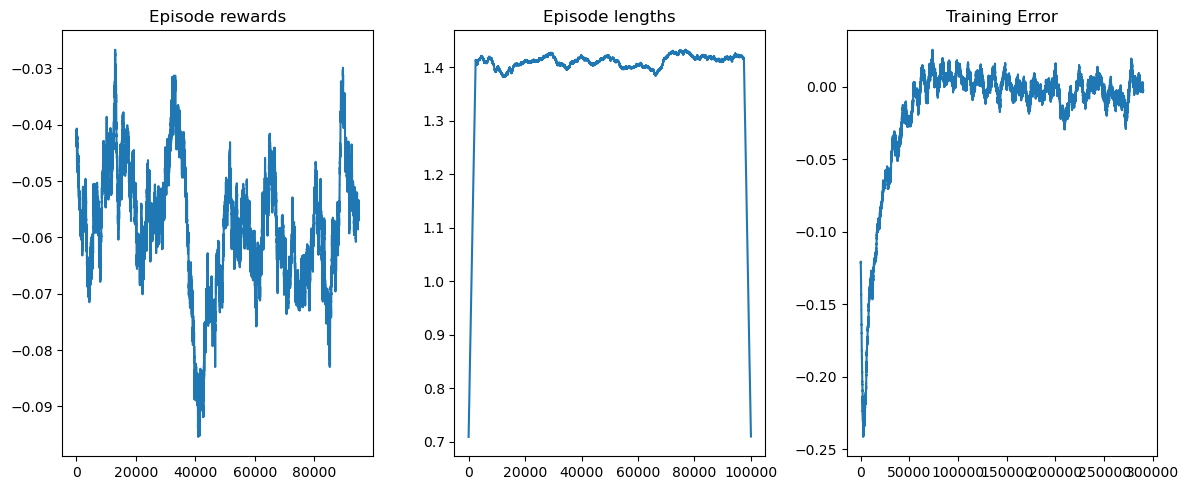

In [9]:
training_plot(env.return_queue, env.length_queue, agent.training_error, 5000)

## Visualizing the testing with SARSA Algorithm




[-1.000e+00 -2.000e+00 -3.000e+00 ... -5.917e+03 -5.916e+03 -5.915e+03]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.3864 negative:0.5007
Iteration[10000:20000]     positive:0.3768 negative:0.4992
Iteration[20000:30000]     positive:0.3788 negative:0.5018
Iteration[30000:40000]     positive:0.3819 negative:0.4948
Iteration[40000:50000]     positive:0.3793 negative:0.4998
Iteration[50000:60000]     positive:0.3821 negative:0.4973
Iteration[60000:70000]     positive:0.3736 negative:0.5016
Iteration[70000:80000]     positive:0.3795 negative:0.5004
Iteration[80000:90000]     positive:0.3768 negative:0.5032
Iteration[90000:100000]     positive:0.3811 negative:0.4965

====================== Reward Frequency ======================


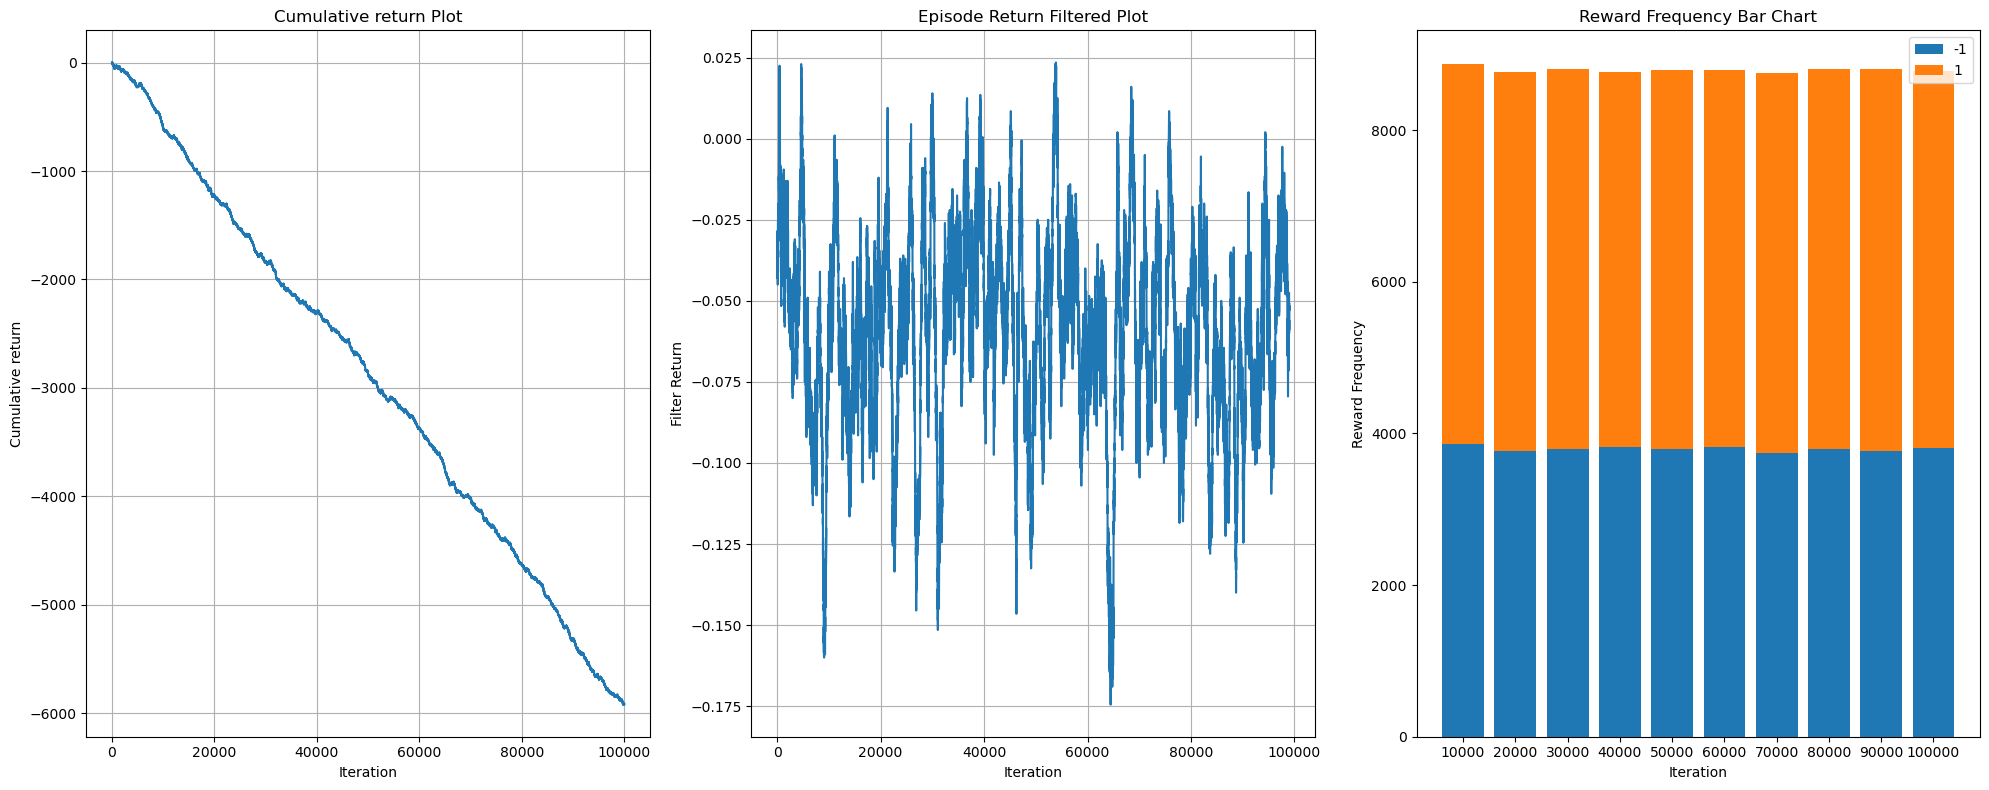

In [9]:
Testing_SARSA_Culmulative_Return_np, Testing_SARSA_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_SARSA_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_SARSA_reward_moving_average)

## Visualizing the training




## Visualising the policy



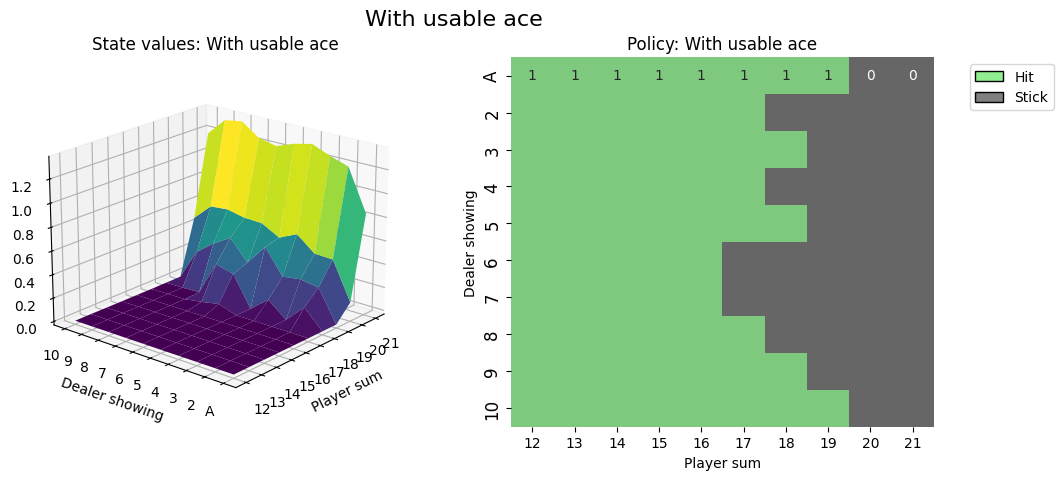

In [105]:
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

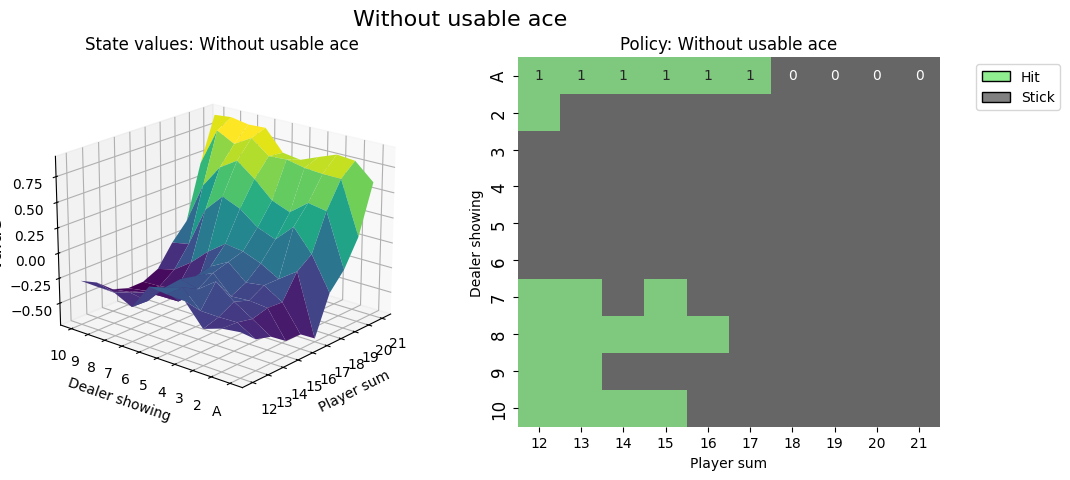

In [104]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

# Double Q-Learning Control

## Parameters Studies for Double Q-Learning Algorithm

Discount 

In [ ]:
#Discount Hyper Paramter Studied
Expected_Return_ls = []
discount_step = 0.01
discount_ls = np.arange(0,1,discount_step)

for i in  discount_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = i

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Discount (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Discount studies with step {} on Double Q-Learning Algorithm'.format(discount_step))
plt.grid(True)
plt.show()
    

Epsilon

In [ ]:
#Epsilon Hyper Paramter Studied
Expected_Return_ls = []
epsilon_step = 0.01
epsilon_ls = np.arange(0,1,discount_step)

for i in  epsilon_ls:
    # hyperparameters
    learning_rate = 0.01
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = i
    discount = 0.01

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)

# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Epsilon (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Epsilon studies with step {} on Double Q-Learning Algorithm'.format(epsilon_step))
plt.grid(True)
plt.show()

Learning Rate

In [ ]:
#Learning Rate Hyper Paramter Studied
Expected_Return_ls = []
learning_rate_step = 0.01
learning_rate_ls = np.arange(learning_rate_step,1,discount_step)

for i in  learning_rate_ls:
    # hyperparameters
    learning_rate = i
    n_episodes = 10000
    start_epsilon = 1.0
    epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
    final_epsilon = 0.01
    discount = 0.01

    control_type == ControlType.DOUBLE_Q_LEARNING

    agent = BlackJackAgent(
        control_type=control_type,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=discount
    )

    env = gym.make("Blackjack-v1", sab=False, natural=True)

    env.observation_space.seed(20)
    np.random.seed(20)

    Expected_Return = 0
    count = 1

    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

    Expected_Return = (np.array(env.return_queue).flatten().sum())/len(np.array(env.return_queue).flatten())
    Expected_Return_ls.append(Expected_Return)


# Generating x values
x = np.arange(len(Expected_Return_ls))

# Performing polynomial fit
degree = 1  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(x, Expected_Return_ls, degree)
polynomial = np.poly1d(coefficients)

# Generating y values for the polynomial
y_fit = polynomial(x)

plt.plot(Expected_Return_ls)
plt.plot(x, y_fit, label='Polynomial Fit')
plt.xlabel('Learning Rate (Step:0.01)')
plt.ylabel('Average Expected Return')
plt.title('Learning Rate studies with step {} on Double Q-Learning Algorithm'.format(learning_rate_step))
plt.grid(True)
plt.show()

## Training Algorithm with 100000 training iterations 

In [10]:
#Training Double Q-Learning
# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.DOUBLE_Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  1%|          | 969/100000 [00:00<00:20, 4831.28it/s]

100%|██████████| 100000/100000 [00:20<00:00, 4805.01it/s]


Save Agent

In [ ]:
#Save Double Q-Learning agent
q_value_file = "double_q_learning.json"
full_path = os.path.abspath("q_value")
agent.save_model(full_path, q_value_file)

## Visualizing the training with Double Q-Learning Algorithm

[ 1.00000e+00  0.00000e+00 -1.00000e+00 ... -1.19515e+04 -1.19505e+04
 -1.19515e+04]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.2793 negative:0.6521
Iteration[10000:20000]     positive:0.2985 negative:0.6234
Iteration[20000:30000]     positive:0.3264 negative:0.5744
Iteration[30000:40000]     positive:0.3519 negative:0.541
Iteration[40000:50000]     positive:0.37 negative:0.5108
Iteration[50000:60000]     positive:0.381 negative:0.4886
Iteration[60000:70000]     positive:0.3916 negative:0.4721
Iteration[70000:80000]     positive:0.3917 negative:0.4757
Iteration[80000:90000]     positive:0.3844 negative:0.4878
Iteration[90000:100000]     positive:0.3868 negative:0.4854

====================== Reward Frequency ======================


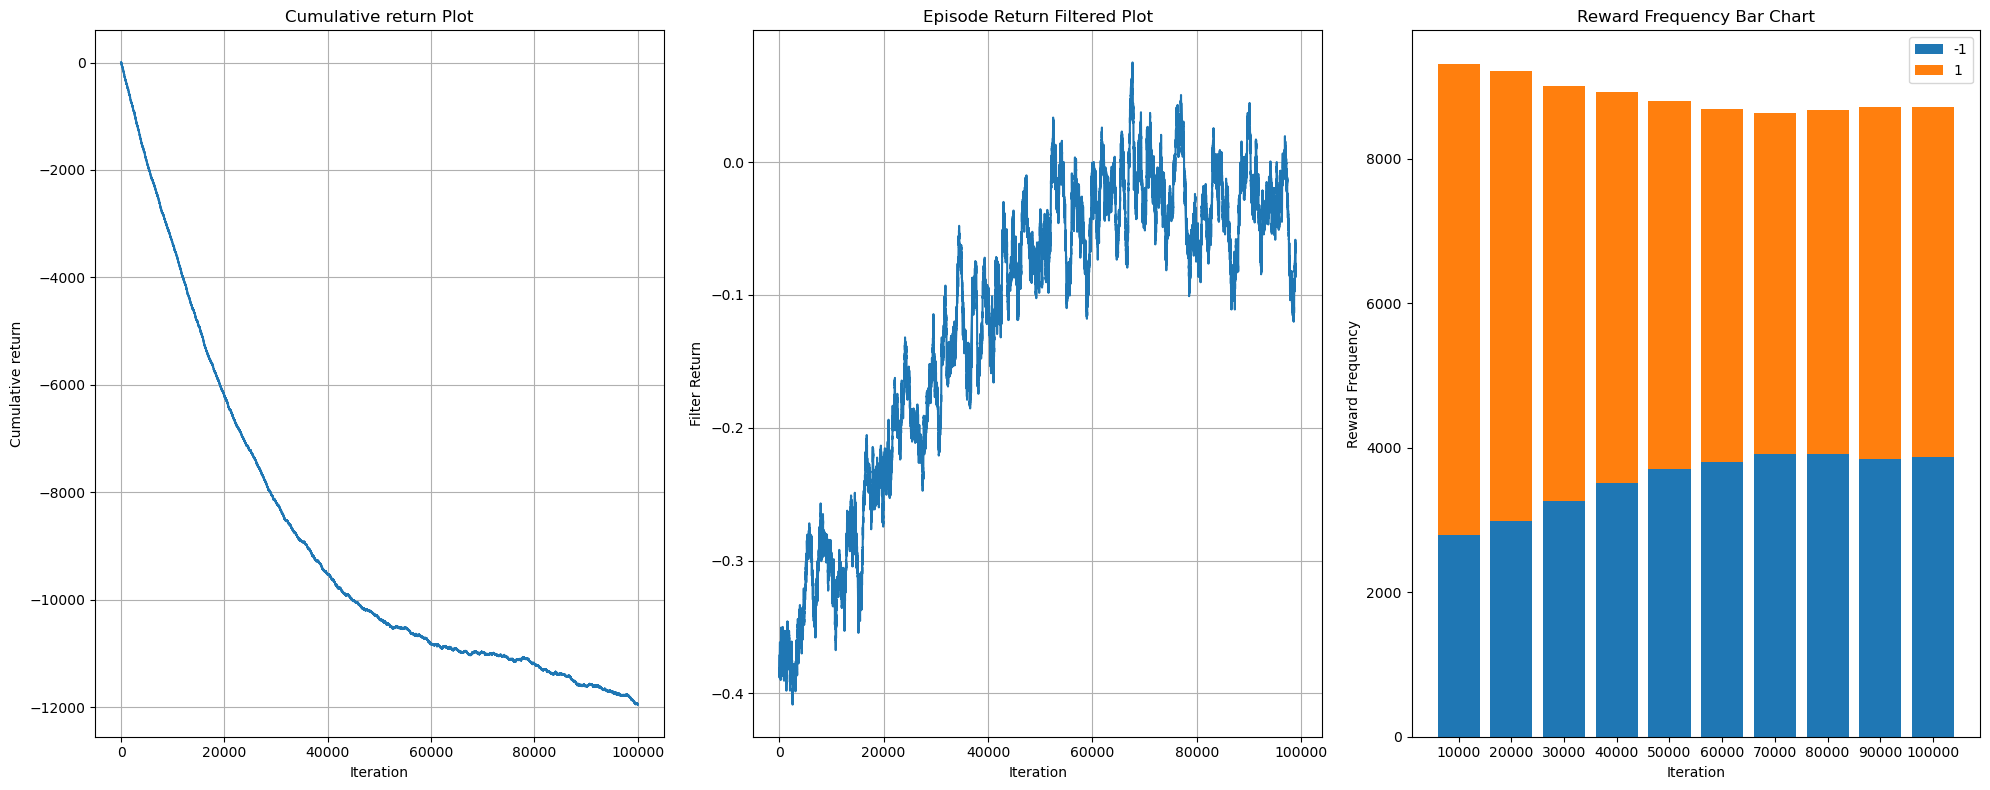

In [11]:
Training_Double_Q_Learning_Culmulative_Return_np, Training_Double_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Training_Culmulative_Return_ls.append(Training_Double_Q_Learning_Culmulative_Return_np)
Training_reward_moving_average_ls.append(Training_Double_Q_Learning_reward_moving_average)

## Testing Algorithm Performance After Double Q-Learning iterations training

Load Agent

In [ ]:
#Load Double Q-Learning Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 0.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.0
discount = 0.01

control_type = ControlType.DOUBLE_Q_LEARNING

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

full_path = os.path.abspath("q_value")
q_value_file = "double_q_learning.json"
agent.load_model(full_path, q_value_file)

defaultdict(<function blackjack.BlackJackAgent.__init__.<locals>.<lambda>()>,
            {(14, 10, 1): [-0.18433351371461296, -0.002355532131535782],
             (21, 10, 1): [2.408436571009574, -0.0001256134460409062],
             (13, 1, 0): [-0.8578865828958018, -0.7858386582644002],
             (9, 3, 0): [-0.18130056171792425, 0.00039083081514029386],
             (21, 6, 1): [2.1474793574871294, -7.3038004196996105e-06],
             (17, 6, 0): [0.08791724282871981, -0.528233862982186],
             (13, 8, 1): [-0.08812477168904989, -0.00019486499931107784],
             (12, 8, 0): [-0.6923137402027155, -0.6296736411324075],
             (13, 8, 0): [-0.7273903130537585, -0.6971393486153781],
             (14, 10, 0): [-1.1085980746863546, -0.9676171040332299],
             (18, 9, 0): [-0.35702596291116506, -0.47405778532610743],
             (12, 1, 0): [-0.6736106214018499, -0.6190188484828645],
             (11, 1, 0): [-0.4078030789081113, -0.0016346417680384467],
   

In [12]:
#Testing Double Q-Learning
env = gym.make("Blackjack-v1", sab=False, natural=True)

env.observation_space.seed(20)
np.random.seed(20)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(
            obs=obs,
            action=action,
            reward=reward,
            next_obs=next_obs,
            terminated=terminated
        )

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

100%|██████████| 100000/100000 [00:20<00:00, 4769.14it/s]


## Visualizing the testing with Double Q-Learning Algorithm




[-1.000e+00 -1.000e+00  0.000e+00 ... -3.561e+03 -3.560e+03 -3.559e+03]
====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.3862 negative:0.483
Iteration[10000:20000]     positive:0.3914 negative:0.4797
Iteration[20000:30000]     positive:0.39 negative:0.4807
Iteration[30000:40000]     positive:0.3817 negative:0.4881
Iteration[40000:50000]     positive:0.3812 negative:0.4892
Iteration[50000:60000]     positive:0.388 negative:0.4803
Iteration[60000:70000]     positive:0.3805 negative:0.4899
Iteration[70000:80000]     positive:0.3903 negative:0.479
Iteration[80000:90000]     positive:0.3875 negative:0.4892
Iteration[90000:100000]     positive:0.3859 negative:0.4826

====================== Reward Frequency ======================


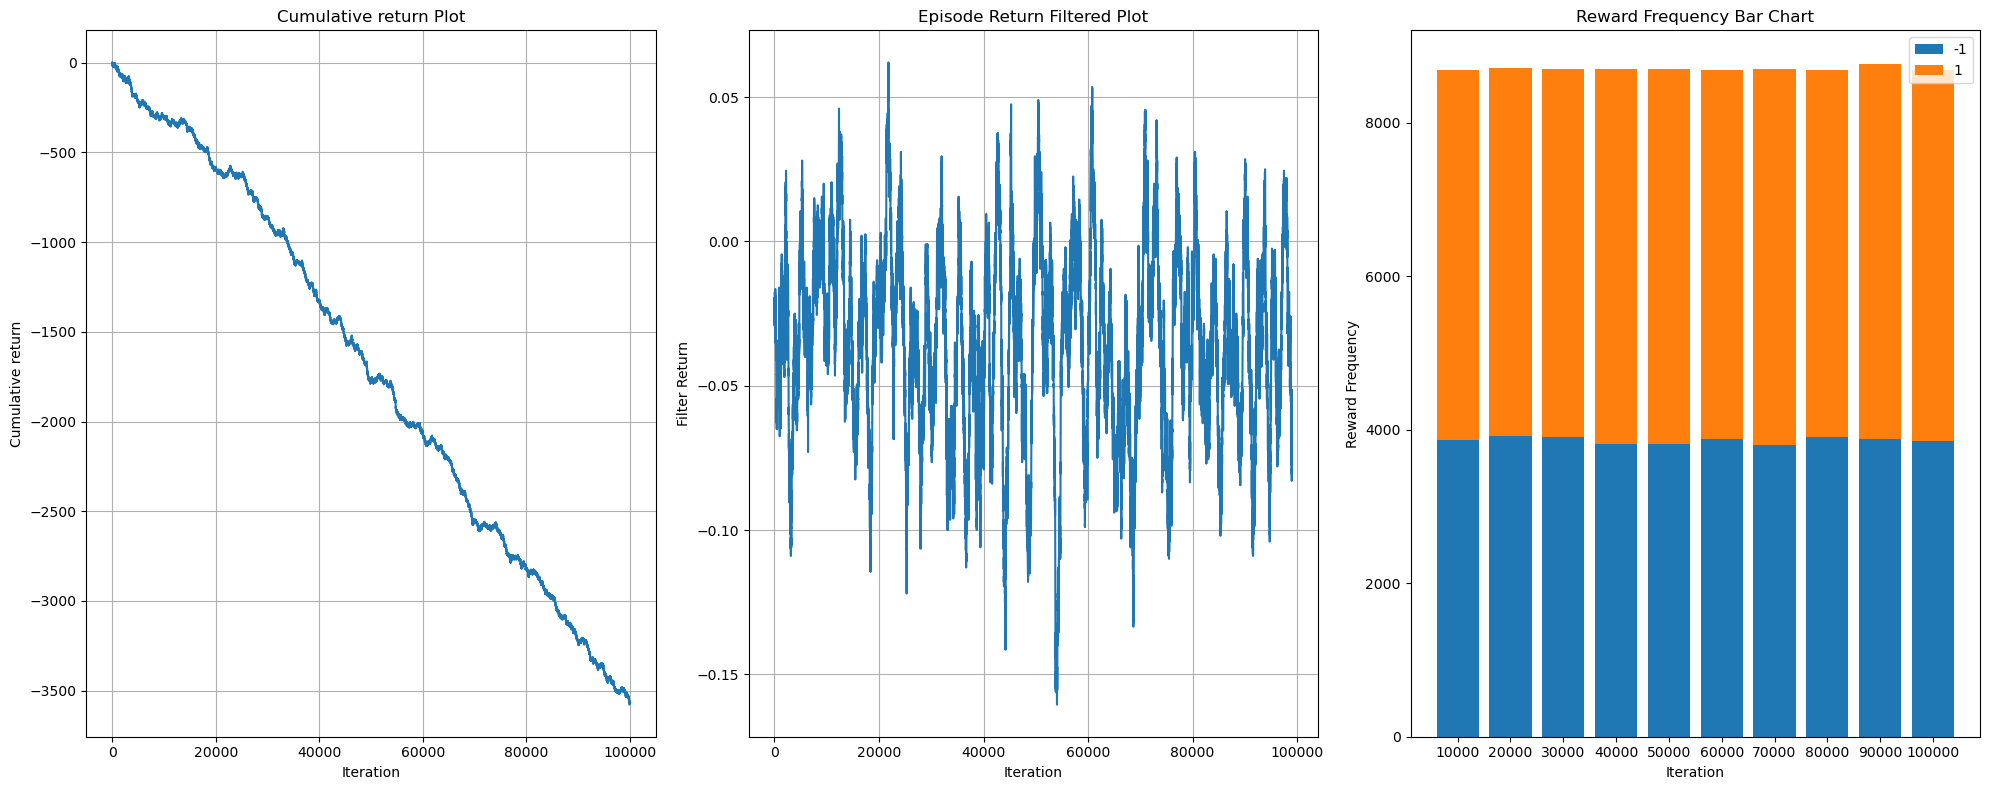

In [13]:
Testing_Double_Q_Learning_Culmulative_Return_np, Testing_Double_Q_Learning_reward_moving_average = reward_plot(n_episodes, 10, env.return_queue)
Testing_Culmulative_Return_ls.append(Testing_Double_Q_Learning_Culmulative_Return_np)
Testing_reward_moving_average_ls.append(Testing_Double_Q_Learning_reward_moving_average)

## Visualising the policy



<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




In [ ]:
training_plot(env.return_queue, env.length_queue, agent.training_error, 5000)

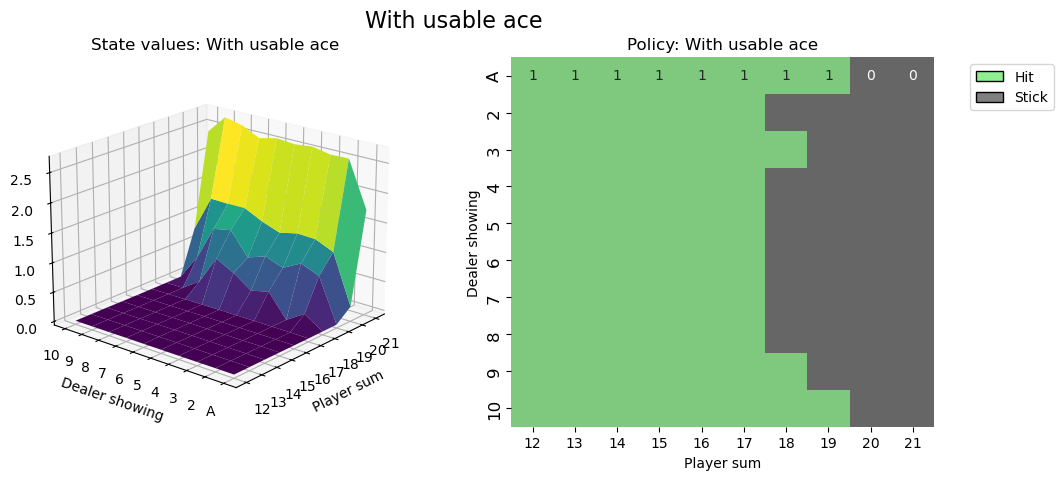

In [98]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

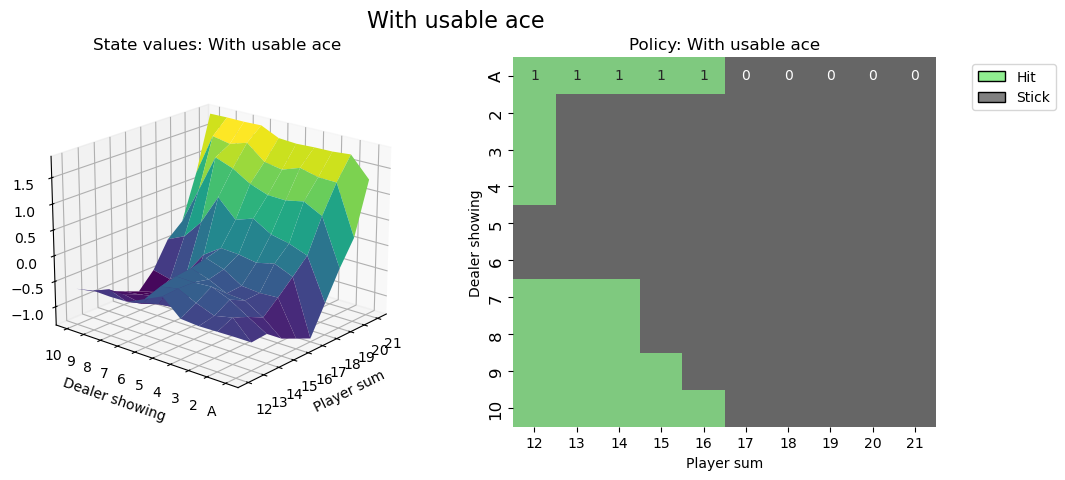

In [99]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# Compare 4 algorithms (Q-Learning, MC, TD, Double Q-Learning) 

================= Expected Return =================
MC:  -0.119935
SARSA:  -0.11852
Double Q-Learning:  -0.119515


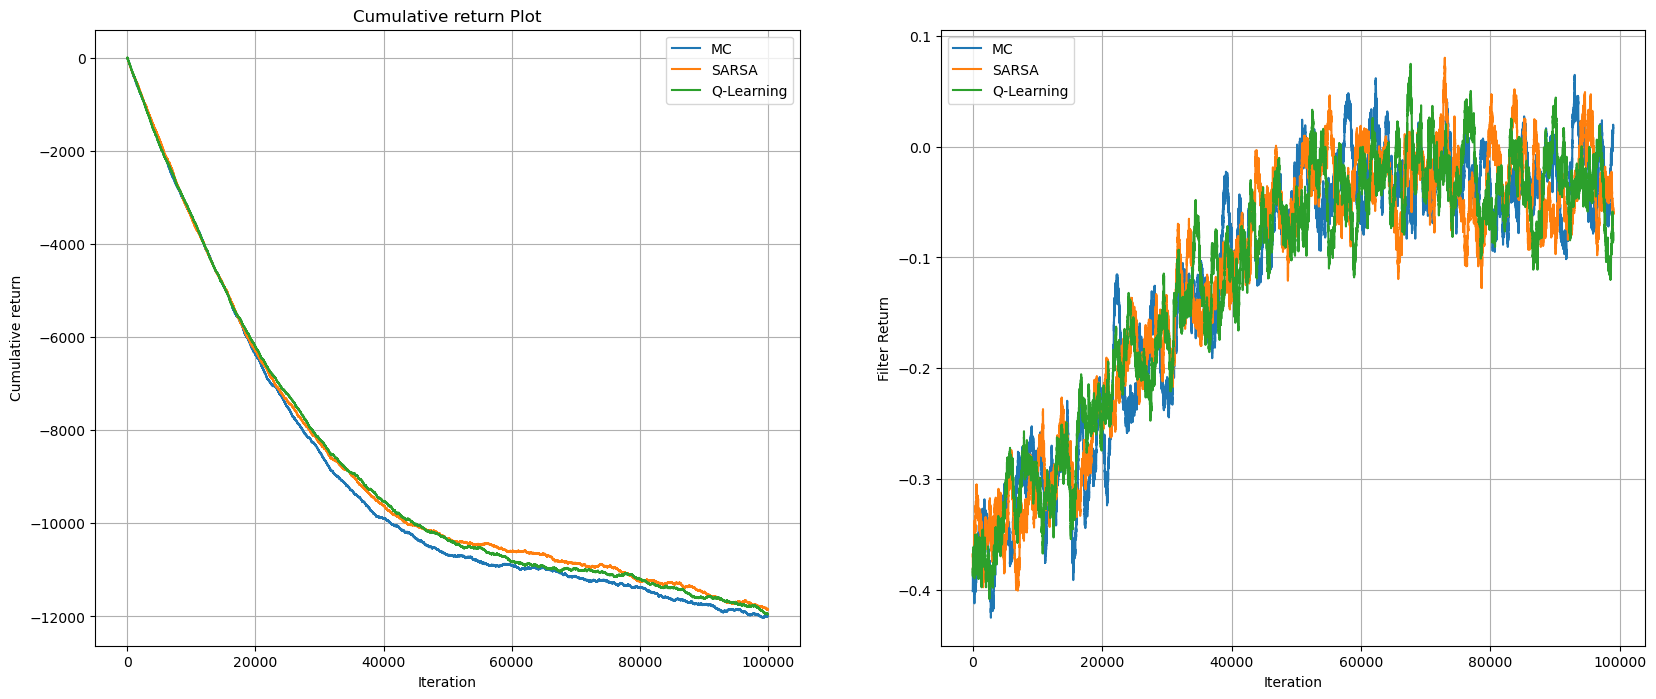

In [14]:
Reward_compare_plot(Training_Culmulative_Return_ls, Training_reward_moving_average_ls)

================= Expected Return =================
MC:  -0.03308
SARSA:  -0.05915
Double Q-Learning:  -0.03559


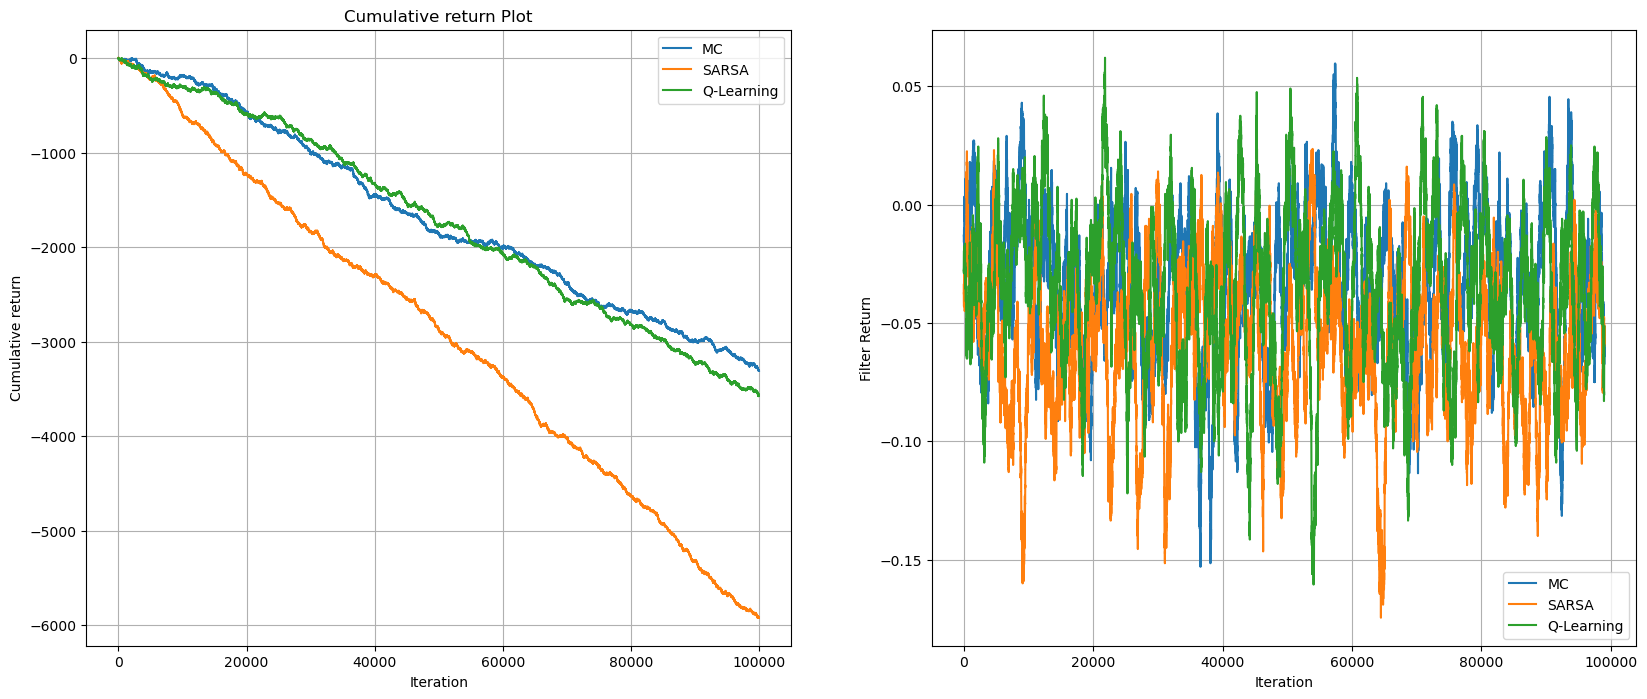

In [15]:
Reward_compare_plot(Testing_Culmulative_Return_ls, Testing_reward_moving_average_ls)